In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

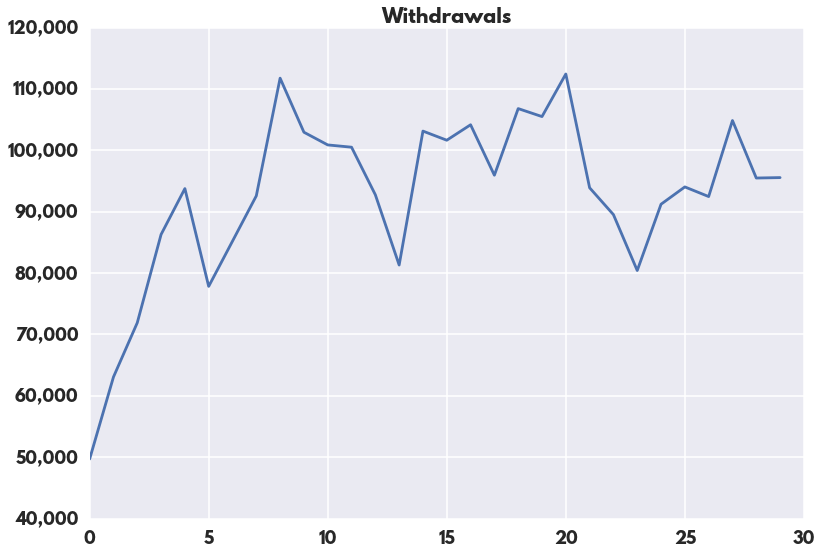

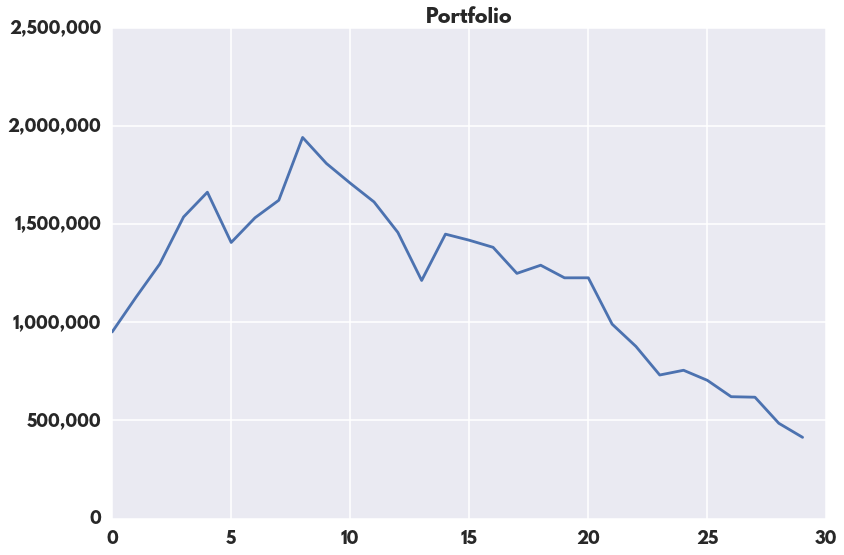

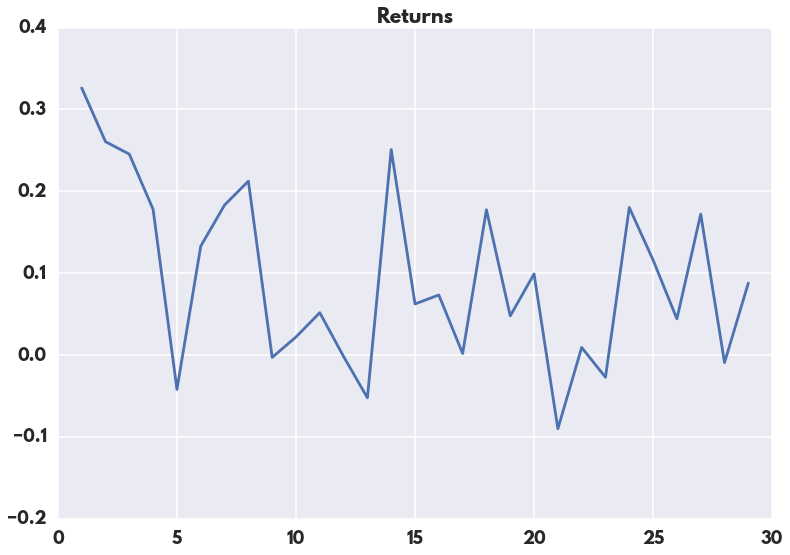

In [2]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_r for n in r], title='Portfolio')
plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [3]:
pprint(['%.2f' % float(n.returns) for n in r[1:]])

['0.33',
 '0.26',
 '0.25',
 '0.18',
 '-0.04',
 '0.13',
 '0.18',
 '0.21',
 '-0.00',
 '0.02',
 '0.05',
 '-0.00',
 '-0.05',
 '0.25',
 '0.06',
 '0.07',
 '0.00',
 '0.18',
 '0.05',
 '0.10',
 '-0.09',
 '0.01',
 '-0.03',
 '0.18',
 '0.12',
 '0.04',
 '0.17',
 '-0.01',
 '0.09']


In [4]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [5]:
iters = 50
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
#ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))
VG = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), withdraw=withdrawal.Vanguard, years=30))

In [6]:
for i in (EM, VG, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.5
90th percentile income 4.37315451314
50th percentile income 2.55549591355
10th percentile income 0.0143881780436
5th percentile income 0.0136936517242
1st percentile income 0.0128616731378

Success rate 0.54
90th percentile income 3.48037801727
50th percentile income 2.54450667682
10th percentile income 0.0131607401284
5th percentile income 0.0129903052411
1st percentile income 0.0121043112438

Success rate 1.0
90th percentile income 4.49661521232
50th percentile income 2.64252851665
10th percentile income 1.27058291308
5th percentile income 0.974263457341
1st percentile income 0.812654563097



In [7]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.025)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [8]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.043246615339242594
stocks 0.010449686978220607
bonds 0.05005737721833815
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.010107  0.000000  0.168352  0.118061   0.013454
1   0.010107  0.010000  0.000000  0.136504  0.108518  -0.003091
2   0.010000  0.023992  0.011959 -0.312778 -0.140015   0.042238
3   0.023992  0.026430  0.018670 -0.262814  0.004885   0.052057
4   0.026430  0.038214  0.016159  0.303788  0.000111   0.018904
5   0.038214  0.043195  0.035825 -0.170956  0.023376   0.053420
6   0.043195  0.056291  0.047101 -0.046583  0.032762   0.030788
7   0.056291  0.057344  0.036775  0.009109  0.145825   0.076333
8   0.057344  0.060898  0.030642  0.067702  0.054024   0.044125
9   0.060898  0.061351  0.036780  0.235195  0.028444   0.027014
10  0.061351  0.065025  0.030879  0.121657  0.095329   0.027579
11  0.065025  0.067840  0.029703  0.101499  0.051125  -0.019254
12  0.067840  0.0

In [9]:
iters = 100

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [10]:
s.median()

0.047

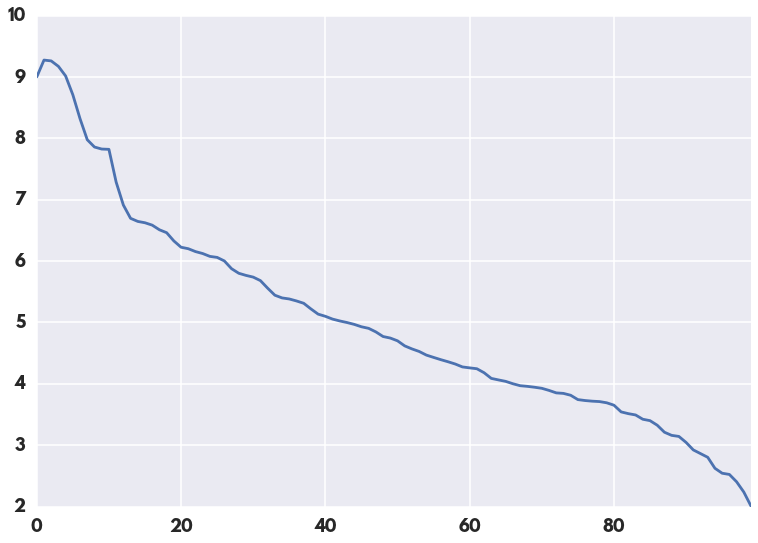

In [11]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [13]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 100
successes = 0
for i in range(iters):
    final_age = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_fn=survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.033')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

1.0


In [14]:
iters = 100
successes = 0
couple = [mortality.Person(age=65, gender=mortality.MALE), mortality.Person(age=60, gender=mortality.FEMALE)]
for i in range(iters):
    final_age = 65 + mortality.gen_lifespan(couple)
    sim_results = simulate.withdrawals(montecarlo.historical[60],
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('.05')),
                         years=final_age - 65)
    if sim_results[-1].portfolio_n > 0:
        successes += 1
print(successes/iters)

0.75
